In [ ]:
#import framework, library dan modul yang dibutuhkan

import h5py #modul untuk mengolah file Hierarchical Data Format (HDF) - Dataset
import numpy #modul untuk mengolah numpy array
import tensorflow #menggunakan framework tensorflow
from tensorflow import keras #menggunakan library keras
import matplotlib.pyplot as plt #modul untuk ploting array
from tensorflow.keras import layers, Model, applications, utils #modul pada pada keras
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import Dense, MaxPool2D , Flatten #kelas pada modul models di library keras

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

#download dataset dan unzip
! kaggle datasets download -d dhandiyy/nitruavcorridorv1
! unzip nitruavcorridorv1.zip

#download dataset dan unzip
#! kaggle datasets download -d dhandiyy/weights-ku
#! unzip weights-ku.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 6.33G/6.34G [02:27<00:00, 38.4MB/s]
100% 6.34G/6.34G [02:27<00:00, 46.1MB/s]
Archive:  nitruavcorridorv1.zip
  inflating: TestRotation(Distance).h5  
  inflating: TestTranslation(Angle).h5  
  inflating: TrainRotation(Distance).h5  
  inflating: TrainTranslation(Angle).h5  


In [ ]:
#DATASET FOR ROTATION
#---------------------------------------------------------

#inisiasi path letak data train untuk rotasi pada variabel
train_rot = '/content/TrainRotation(Distance).h5' 
#inisiasi path letak data test untuk rotasi pada variabel
test_rot = '/content/TestRotation(Distance).h5'

#read hdf5 file
f = h5py.File(train_rot, 'r') #membaca file pada variabel train_rot dan memasukannya ke varibel f
input_train_rot = f['xtrain'][...] #load data di variabel f untuk data berlabel 'xtrain'
label_train_rot = f['ytrain'][...] #load data di variabel f untuk data berlabel 'ytrain'
f.close() #close file

f = h5py.File(test_rot, 'r') #membaca file pada variabel test_rot dan memasukannya ke varibel f
input_test_rot = f['xtest'][...] #load data di variabel f untuk data berlabel 'xtest'
label_test_rot = f['ytest'][...] #load data di variabel f untuk data berlabel 'ytest'
f.close() #close file

In [ ]:
#DATASET FOR TRANSLATION
#---------------------------------------------------------

#inisiasi path letak data train untuk rotasi pada variabel
train_tran = '/content/TrainTranslation(Angle).h5' 
#inisiasi path letak data test untuk rotasi pada variabel
test_tran = '/content/TestTranslation(Angle).h5'

#read hdf5 file
f = h5py.File(train_tran, 'r') #membaca file pada variabel train_rot dan memasukannya ke varibel f
input_train_tran = f['xtrain'][:21000] #load data di variabel f untuk data berlabel 'xtrain'
label_train_tran = f['ytrain'][:21000] #load data di variabel f untuk data berlabel 'ytrain'
f.close() #close file

f = h5py.File(test_tran, 'r') #membaca file pada variabel test_rot dan memasukannya ke varibel f
input_test_tran = f['xtest'][...] #load data di variabel f untuk data berlabel 'xtest'
label_test_tran = f['ytest'][...] #load data di variabel f untuk data berlabel 'ytest'
f.close() #close file

In [ ]:
# show preferred channel order
from keras import backend
backend.set_image_data_format('channels_first')
print(backend.image_data_format())

#Menggunakan Pre-trained Model Resnet50

#inisiasi arsitektur pada ResNet50V2
pre_trained_model = tensorflow.keras.applications.ResNet50V2( 
    include_top=False, #tidak menggunakan Fully Connected layer
    weights="imagenet" #menggunakan weights pada dataset ImageNet
     #input ukuran gambar yang akan dimasukan ke model
)

pre_trained_model.trainable = False #untuk tidak dilakukan training ulang pada model

#Membuat model baru untuk menggantikan Fully Connected layer pada pre-trained model

inputs = keras.Input(shape=(3, 180, 320))
#reshape data
# Pre-trained ResNet50V2 weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`

scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
inputs_fix = scale_layer(inputs)

x = pre_trained_model(inputs_fix, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x) # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


model.summary()

channels_first
94683136/94668760 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 180, 320)]     0         
                                                                 
 rescaling (Rescaling)       (None, 3, 180, 320)       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048, None, None)  23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 256)       

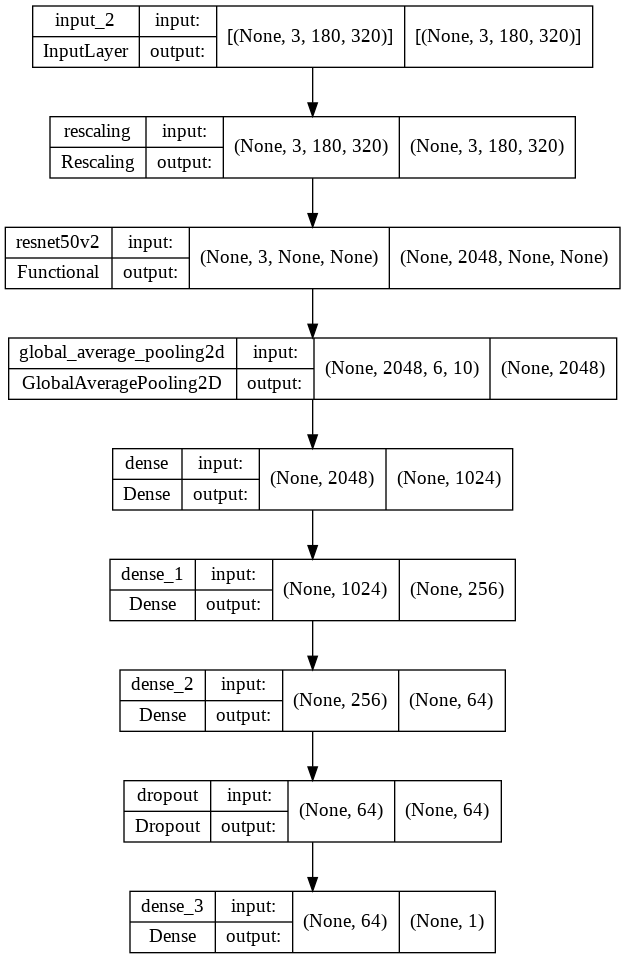

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(
    optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0001), 
    loss=tensorflow.keras.losses.MeanSquaredError(), #semakin kecil loss, ya bagus
    metrics=[tensorflow.keras.metrics.MeanSquaredError()]
)

epochs = 50
history = model.fit(input_train_rot, label_train_rot,
                    batch_size= 50,
                    epochs=epochs, verbose=1,
                    validation_data=(input_test_rot, label_test_rot)
                    )

Epoch 1/50


InvalidArgumentError: ignored

In [ ]:
#model.save('test_model.h5')
from google.colab import files
model.save_weights('rot_model_weights.h5')
files.download('rot_model_weights.h5')

In [ ]:
acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='error')
plt.plot(epochs, val_acc, 'b', label='val error')
plt.title('Training and validation error (MSE)')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('loss and validation loss(MSE)')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
# load model
weights = '/content/mse_rot_model_weights.h5'

model.load_weights(weights)

#fine-tuning
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
pre_trained_model.trainable = True

model.compile(
    optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-5), 
    loss=tensorflow.keras.losses.MeanSquaredError(), #semakin kecil loss, ya bagus
    metrics=[tensorflow.keras.metrics.MeanSquaredError()]
)
epochs = 10
history = model.fit(input_train_rot, label_train_rot,
                    batch_size= 50,
                    epochs=epochs, verbose=1,
                    validation_data=(input_test_rot, label_test_rot)
                    )

Epoch 1/10
420/420 [==============================] - 247s 533ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 2/10
420/420 [==============================] - 231s 550ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 3/10
420/420 [==============================] - 231s 550ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 4/10
420/420 [==============================] - 231s 551ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 5/10
420/420 [==============================] - 231s 550ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 6/10
420/420 [==============================] - 231s 551ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoc

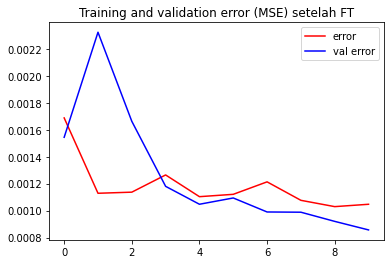

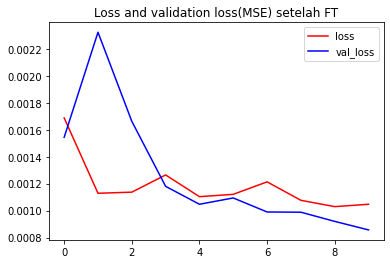

<Figure size 432x288 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='error')
plt.plot(epochs, val_acc, 'b', label='val error')
plt.title('Training and validation error (MSE) setelah FT')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('Loss and validation loss(MSE) setelah FT')
plt.legend(loc=0)
plt.figure()
plt.show()

#model.save('test_model.h5')
from google.colab import files
model.save('rot_model_mse.h5')
files.download('rot_model_mse.h5')

0.16


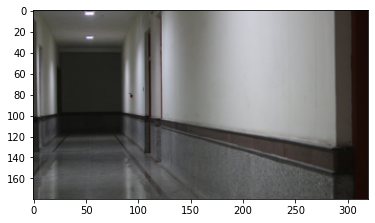

In [ ]:
x = 1
plt.imshow(numpy.moveaxis(input_test_rot[x], 0, -1))
print(label_test_rot[x])

In [ ]:
predictions = model.predict(input_test_rot)
hasil = predictions[1]
print(hasil)

IndexError: ignored